<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/deagwon/Dacon_satellite_modifiedVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
 
warnings.filterwarnings("ignore")

In [0]:
# style 설정
plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

In [10]:
tf.__version__

'2.2.0-rc4'

## 데이터 받아오기

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train_features = np.load('/content/drive/My Drive/2020 Kaggle Study/deagwon/train_featrues.npy')

## 모델만들기

In [0]:
'''
print('data load...')
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_add.npy')
train_time = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_time.csv')

test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_time = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/test_time.csv')

train_DEM = np.load('/content/drive/My Drive/2020 Kaggle Study/DEM_DPR/dem_train_DPR.npy')
test_DEM = np.load('/content/drive/My Drive/2020 Kaggle Study/DEM_DPR/dem_test_DPR.npy')

train_days = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_days.npy')
train_times = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_times.npy')

test_days = np.load( '/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/test_days.npy')
test_times = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/test_times.npy')
print('load completed')

train_features = np.zeros([train.shape[0],40,40,15], np.float32)
train_features[:,:,:,:9] = train[:,:,:,:9]
train_features[:,:,:,9] = train_DEM[:,:,:,0]####DEM
train_features[:,:,:,10] = train_days[:,:,:,0]###day sin
train_features[:,:,:,11] = train_days[:,:,:,1]### day cos
train_features[:,:,:,12] = train_times[:,:,:,0]# time sin
train_features[:,:,:,13] = train_times[:,:,:,1]# time cos
train_features[:,:,:,14] = train[:,:,:,-1]

test_features = np.zeros([test.shape[0],40,40,14], np.float32)
test_features[:,:,:,:9] = test[:,:,:,:9]
test_features[:,:,:,9] = test_DEM[:,:,:,0]####DEM
test_features[:,:,:,10] = test_days[:,:,:,0]###day sin
test_features[:,:,:,11] = test_days[:,:,:,1]### day cos
test_features[:,:,:,12] = test_times[:,:,:,0]# time sin
test_features[:,:,:,13] = test_times[:,:,:,1]# time cos
#test_features[:,:,:,14] = test[:,:,:,-1]

del train
gc.collect()
np.save('/content/drive/My Drive/2020 Kaggle Study/deagwon/train_featrues.npy', train_features)


In [0]:
def build_model(input_layer, start_neurons):

    #40 40 -> 20 20
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(input_layer)
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(conv1)
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(conv1)
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(conv1)
    conv1 = BatchNormalization(momentum=0.15)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(pool1)
    model_20 = Dropout(rate=0.3)(pool1)

    #20 20 -> 10 10
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model_20)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(conv2)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(conv2)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(conv2)
    conv2 = BatchNormalization(momentum=0.15)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(pool2)
    pool2 = BatchNormalization(momentum=0.15)(pool2)
    model_10 = Dropout(rate=0.3)(pool2)

    # 10 10 -> 5 5 
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model_10)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(conv3)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(conv3)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(conv3)
    conv3 = BatchNormalization(momentum=0.15)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(pool3)
    pool3 = BatchNormalization(momentum=0.15)(pool3)
    model_5 = Dropout(rate=0.3)(pool3)
    
    ##
    model_20_up = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same")(model_20)#20 ->40

    model_10_up = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(model_10)#10 -> 20
    model_10_up = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same")(model_10_up)#20 ->40

    model_5_up = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(model_5)# 5 -> 10
    model_5_up = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same")(model_5_up)# 10 -> 20
    model_5_up = Conv2DTranspose(8, (3, 3), strides=(2, 2), padding="same")(model_5_up)# 20 -> 40



    model = concatenate([conv1, model_20_up, model_10_up, model_5_up])



    model = Dropout(0.25)(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(0.25)(model)
    output_layer = Conv2D(filters=1, kernel_size=(3, 3), padding='SAME', activation='relu')(model)

    return output_layer

input_layer = Input((40, 40, 14)) ## dem, month_sin, month_cos 추가
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 40, 14)] 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 40, 40, 32)   4064        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 40, 40, 32)   9248        conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 40, 40, 32)   9248        conv2d_41[0][0]                  
____________________________________________________________________________________________

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [32]:
gc.collect()
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train_features):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for index, file in enumerate(train_features[train_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            if (cutoff_labels > 0).sum() < 50:
                continue
            feature = file[:,:,:14]## 0번 ~ 8번 
            yield (feature, cutoff_labels)
    
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,14]),###### dem, month_sin, month_cos 추가
                                                    tf.TensorShape([40,40,1])))##### target
    train_dataset = train_dataset.batch(512).prefetch(1)
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
    def testGenerator():
        for index, file in enumerate(train_features[test_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            if (cutoff_labels > 0).sum() < 50:
                continue
            feature = file[:,:,:14]
            yield (feature, cutoff_labels)

    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,14]),########################land type 추가, month 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

   

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)
    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
49/49 [==============================] - 47s 967ms/step - loss: 0.3540 - maeOverFscore_keras: 8.0634 - fscore_keras: 0.3328 - val_loss: 0.3534 - val_maeOverFscore_keras: 28.5728 - val_fscore_keras: 0.0782
Epoch 2/10
49/49 [==============================] - 45s 913ms/step - loss: 0.3074 - maeOverFscore_keras: 4.7966 - fscore_keras: 0.4632 - val_loss: 0.3046 - val_maeOverFscore_keras: 4.2041 - val_fscore_keras: 0.4512
Epoch 3/10
49/49 [==============================] - 45s 917ms/step - loss: 0.2968 - maeOverFscore_keras: 3.5804 - fscore_keras: 0.5183 - val_loss: 0.3318 - val_maeOverFscore_keras: 9.2649 - val_fscore_keras: 0.2253
Epoch 4/10
49/49 [==============================] - 45s 910ms/step - loss: 0.2926 - maeOverFscore_keras: 3.4062 - fscore_keras: 0.5318 - val_loss: 0.2920 - val_maeOverFscore_keras: 3.2029 - val_fscore_keras: 0.5558
Epoch 5/10
49/49 [==============================] - 45s 920ms/step - loss: 0.2848 - maeOverFscore_keras: 3.1613 - fscore_keras: 0.5

In [40]:
## 모델 저장하기
model.save('modify_VGG_dem_day_time_10e_5f.h5')
!cp model_dem_day_time_10e_5f.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

cp: cannot stat 'model_dem_day_time_10e_5f.h5': No such file or directory


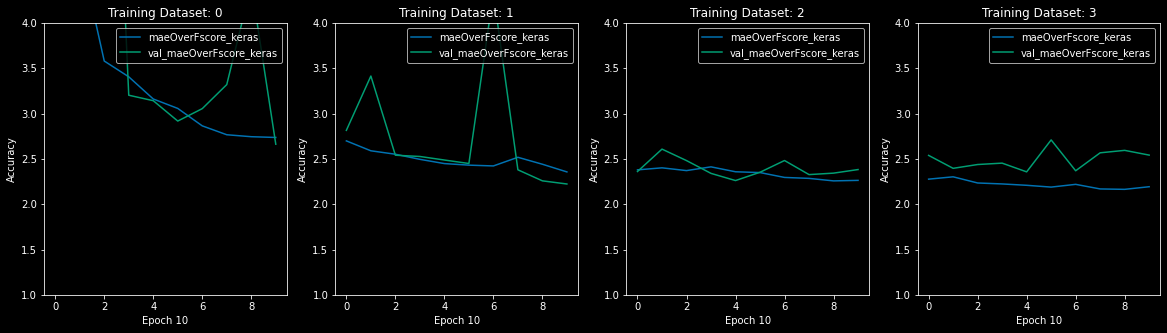

In [41]:
plt.figure(figsize = (20,5))
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plt.subplot(1,4,dataset+1)
    #plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    #plt.style.use('ggplot')
    plt.plot(np.arange(0, 10), model_history[dataset].history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, 10), model_history[dataset].history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title( f'Training Dataset: {dataset}')
    plt.xlabel(f'Epoch {10}')
    plt.ylabel('Accuracy')
    plt.ylim(1,4)
    plt.legend(loc='upper right')
plt.show()


## 두번째 훈련

In [42]:
gc.collect()
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train_features):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for index, file in enumerate(train_features[train_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            if (cutoff_labels > 0).sum() < 50:
                continue
            feature = file[:,:,:14]## 0번 ~ 8번 
            yield (feature, cutoff_labels)
    
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,14]),###### dem, month_sin, month_cos 추가
                                                    tf.TensorShape([40,40,1])))##### target
    train_dataset = train_dataset.batch(512).prefetch(1)
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
    def testGenerator():
        for index, file in enumerate(train_features[test_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            if (cutoff_labels > 0).sum() < 50:
                continue
            feature = file[:,:,:14]
            yield (feature, cutoff_labels)

    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,14]),########################land type 추가, month 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

   

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)
    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
48/48 [==============================] - 48s 990ms/step - loss: 0.2428 - maeOverFscore_keras: 2.1370 - fscore_keras: 0.6951 - val_loss: 0.2378 - val_maeOverFscore_keras: 2.0413 - val_fscore_keras: 0.7154
Epoch 2/10
48/48 [==============================] - 45s 943ms/step - loss: 0.2424 - maeOverFscore_keras: 2.1021 - fscore_keras: 0.7042 - val_loss: 0.2406 - val_maeOverFscore_keras: 2.1066 - val_fscore_keras: 0.6986
Epoch 3/10
48/48 [==============================] - 46s 949ms/step - loss: 0.2406 - maeOverFscore_keras: 2.0668 - fscore_keras: 0.7108 - val_loss: 0.2461 - val_maeOverFscore_keras: 2.2712 - val_fscore_keras: 0.6732
Epoch 4/10
48/48 [==============================] - 46s 956ms/step - loss: 0.2406 - maeOverFscore_keras: 2.0690 - fscore_keras: 0.7098 - val_loss: 0.2422 - val_maeOverFscore_keras: 2.2142 - val_fscore_keras: 0.6814
Epoch 5/10
48/48 [==============================] - 45s 947ms/step - loss: 0.2398 - maeOverFscore_keras: 2.0434 - fscore_keras: 0.71

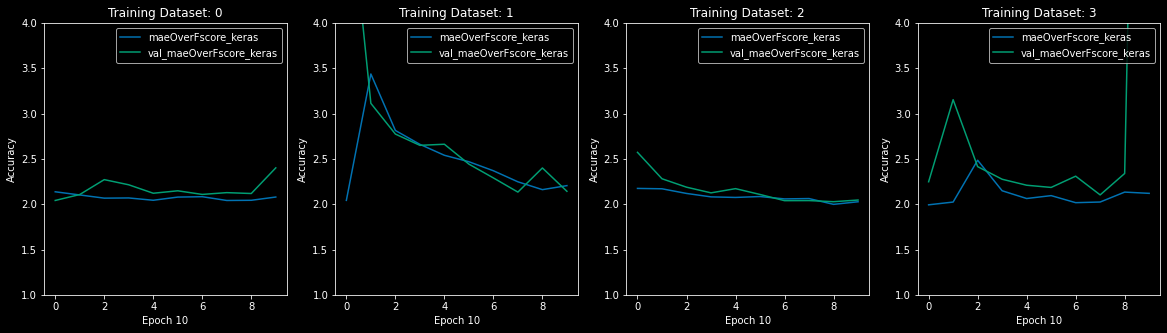

In [43]:
plt.figure(figsize = (20,5))
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plt.subplot(1,4,dataset+1)
    #plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    #plt.style.use('ggplot')
    plt.plot(np.arange(0, 10), model_history[dataset].history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, 10), model_history[dataset].history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title( f'Training Dataset: {dataset}')
    plt.xlabel(f'Epoch {10}')
    plt.ylabel('Accuracy')
    plt.ylim(1,4)
    plt.legend(loc='upper right')
plt.show()


## submission 만들기

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_submit = test_submit[:,:,:,:10]
del test_submit
gc.collect()
pred = model.predict(test_submit)

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'

90% = 198.43, 10% = 188.97


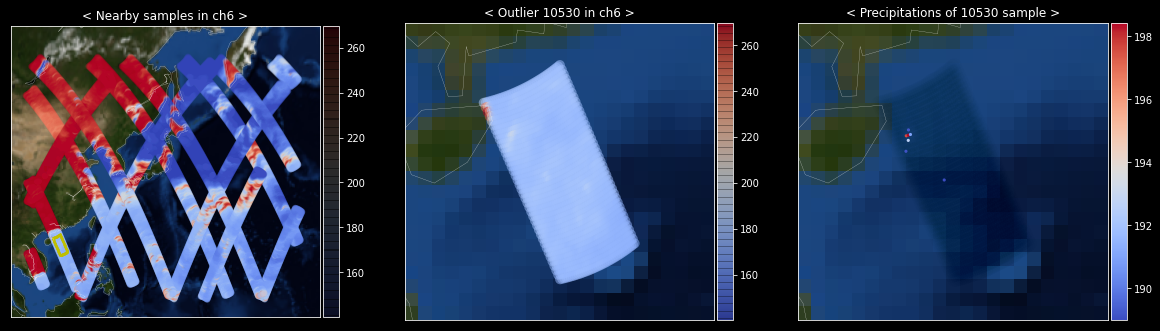

In [0]:
plot_outlier_in_earth(index = outlier_index[5], ch = 6)

90% = 259.24, 10% = 216.81


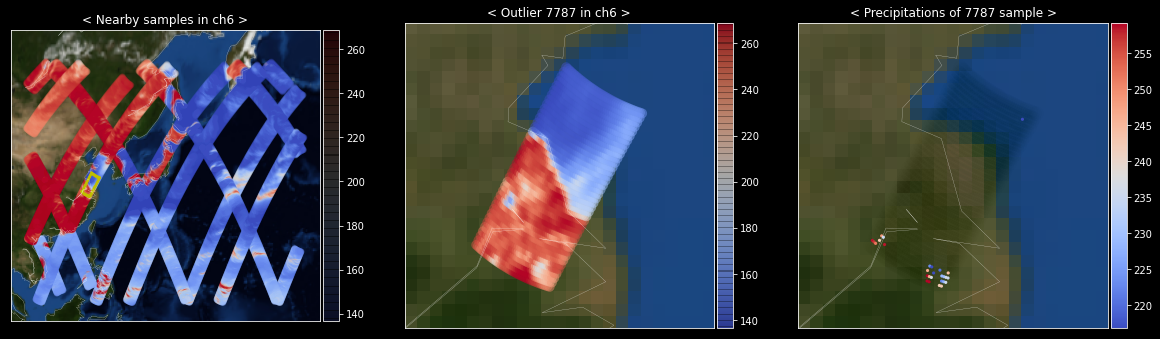

In [0]:
plot_outlier_in_earth(index = outlier_index[4], ch = 6)